# Understanding Regression Parameters

This section of notes aims to dig a bit more into what the simple linear regression (ie., regression with a single continuous covariate) parameters mean. We will consider the estimation formulas in part of this to gain a sense of how these can be computed. 

## New Example Data
The new data for this section of notes will explore data from the [Environmental Protection Agency on Air Quality](https://www.epa.gov/outdoor-air-quality-data) collected for the state of Iowa in 2021. The data are daily values for PM 2.5 particulates. The attributes included in the data are shown below with a short description.

| Variable | Description | 
|:---------|:------------|
| date      | Date of observation |
| id | Site ID |
| poc | Parameter Occurrence Code (POC) |
| pm2.5 | Average daily pm 2.5 particulate value, in (ug/m3; micrograms per meter cubed) |
| daily_aqi | Average air quality index |
| site_name | Site Name |
| aqs_parameter_desc | Text Description of Observation |
| cbsa_code | Core Based Statistical Area (CBSA) ID |
| cbsa_name | CBSA Name |
| county | County in Iowa |
| avg_wind | Average daily wind speed (in knots) | 
| max_wind | Maximum daily wind speed (in knots) | 
| max_wind_hours | Time of maximum daily wind speed |


### Guiding Question
How is pm2.5 related to the daily air quality index?

## Bivariate Figure

Note, below I do a bit of post-processing to combine data from different POC values within a single CBSA.

In [14]:
library(tidyverse)
library(ggformula)
library(mosaic)

theme_set(theme_bw(base_size = 18))

airquality <- readr::read_csv("https://raw.githubusercontent.com/lebebr01/psqf_6243/main/data/iowa_air_quality_2021.csv")
wind <- readr::read_csv("https://raw.githubusercontent.com/lebebr01/psqf_6243/main/data/daily_WIND_2021-iowa.csv")

airquality <- airquality %>%
   left_join(wind, by = c('cbsa_name', 'date')) %>% 
   drop_na()

Rows: 6917 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): date, site_name, aqs_parameter_desc, cbsa_name, county
dbl (5): id, poc, pm2.5, daily_aqi, cbsa_code


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 1537 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): date, cbsa_name
dbl (3): avg_wind, max_wind, max_wind_hours


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [16]:
head(airquality)
dim(airquality)

date,id,poc,pm2.5,daily_aqi,site_name,aqs_parameter_desc,cbsa_code,cbsa_name,county,avg_wind,max_wind,max_wind_hours
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1/1/21,190130009,1,15.1,57,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.941667,5.8,17
1/4/21,190130009,1,13.3,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.445833,3.6,20
1/7/21,190130009,1,20.5,69,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.995833,3.1,13
1/10/21,190130009,1,14.3,56,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,3.445833,5.0,1
1/13/21,190130009,1,13.7,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.116667,2.5,15
1/16/21,190130009,1,5.3,22,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,6.091667,8.9,5


[1] 4821   13

`geom_smooth()` using method = 'gam'



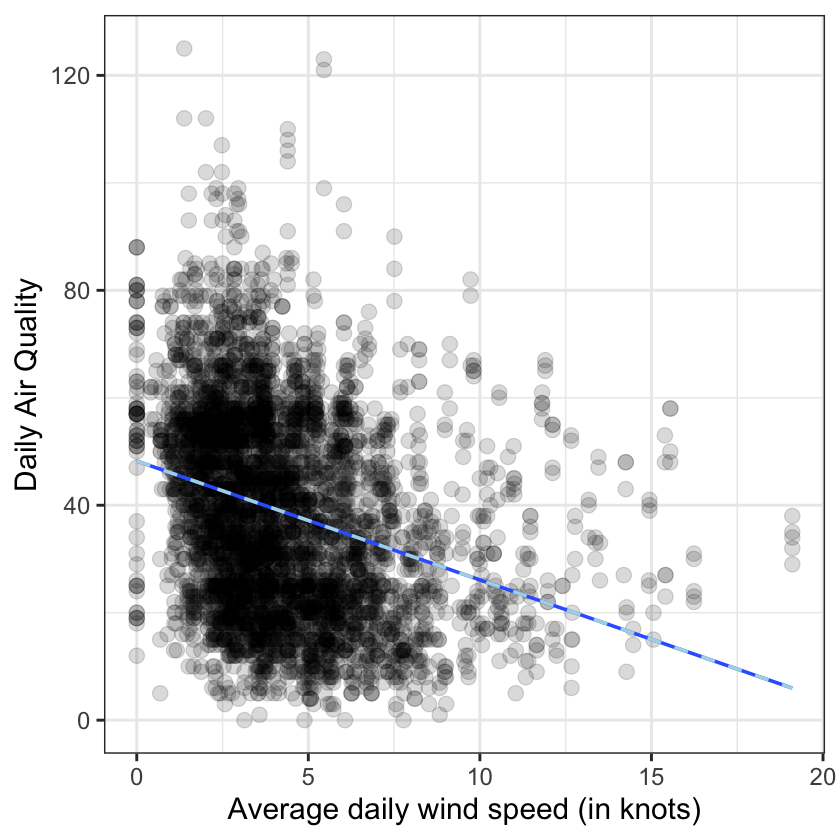

In [17]:
gf_point(daily_aqi ~ avg_wind, data = airquality, size = 4, alpha = .15) %>%
  gf_labs(x = "Average daily wind speed (in knots)",
          y = "Daily Air Quality") %>%
  gf_smooth() %>%
  gf_smooth(method = 'lm', color = 'lightblue', linetype = 2)


In [23]:
cor(daily_aqi ~ avg_wind, data = airquality)

[1] -0.2920277

In [22]:
air_lm <- lm(daily_aqi ~ avg_wind, data = airquality)
coef(air_lm)
summary(air_lm)$r.square
summary(air_lm)$sigma

(Intercept)    avg_wind 
  48.222946   -2.211798

[1] 0.08528019

[1] 18.05479

## Centering predictors

There are times when centering of predictors can be helpful for interpretation of the model parameters. This can be helpful when 0 is not a practically useful characteristic of the attribute or for more specific tests of certain elements of the X attribute. 

### Mean Centering

Mean centering is where the mean of the attribute is subtracted from each value. This is a linear transformation where each data point is subtracted by a constant, the mean. This means that the distance between points do not change.

`geom_smooth()` using method = 'gam'



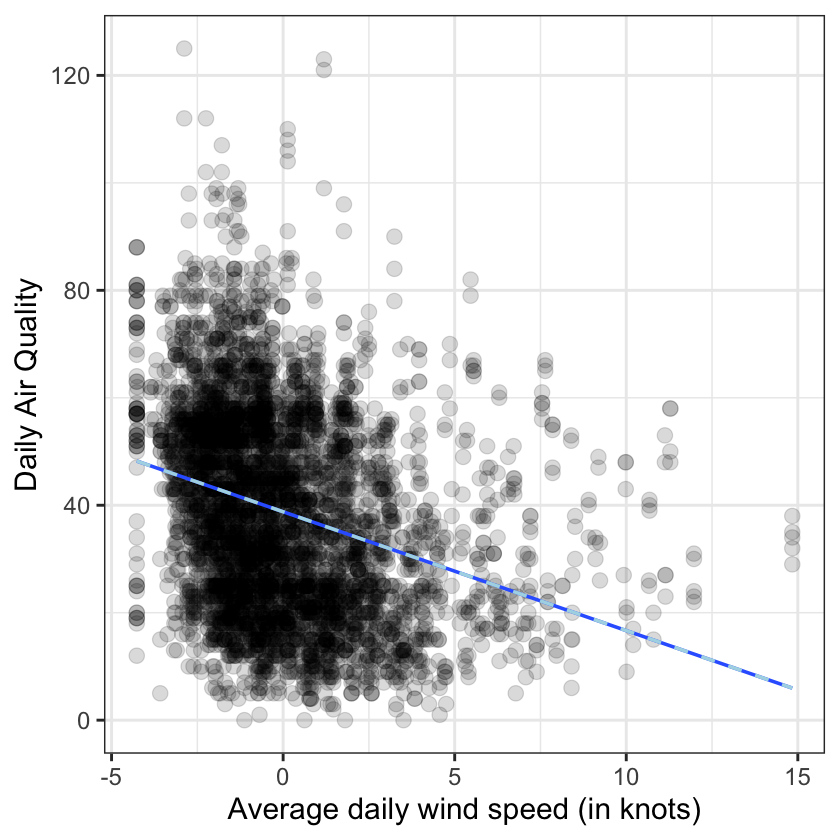

In [24]:
airquality <- airquality %>%
  mutate(avg_wind_mc = avg_wind - mean(avg_wind),
         avg_wind_maxc = avg_wind - max(avg_wind),
         avg_wind_10 = avg_wind - 10)

gf_point(daily_aqi ~ avg_wind_mc, data = airquality, size = 4, alpha = .15) %>%
  gf_labs(x = "Average daily wind speed (in knots)",
          y = "Daily Air Quality") %>%
  gf_smooth() %>%
  gf_smooth(method = 'lm', color = 'lightblue', linetype = 2)

In [25]:
air_lm_mc <- lm(daily_aqi ~ avg_wind_mc, data = airquality)
coef(air_lm_mc)
summary(air_lm_mc)$r.square
summary(air_lm_mc)$sigma

(Intercept) avg_wind_mc 
  38.788011   -2.211798

[1] 0.08528019

[1] 18.05479

In [26]:
air_lm_maxc <- lm(daily_aqi ~ avg_wind_maxc, data = airquality)
coef(air_lm_maxc)
summary(air_lm_maxc)$r.square
summary(air_lm_maxc)$sigma

(Intercept) avg_wind_maxc 
     5.968391     -2.211798

[1] 0.08528019

[1] 18.05479

In [27]:
air_lm_10 <- lm(daily_aqi ~ avg_wind_10, data = airquality)
coef(air_lm_10)
summary(air_lm_10)$r.square
summary(air_lm_10)$sigma

(Intercept) avg_wind_10 
  26.104968   -2.211798

[1] 0.08528019

[1] 18.05479

## Standardized Regression

Another type of regression that can be done is one in which the attributes are standardized prior to estimating the linear regression. What is meant by standardizing? This is converting the attributes into z-scores:

$$ 
Z_{api} = \frac{(aqi - \bar{aqi})}{s_{aqi}}
$$

In [28]:
airquality <- airquality %>%
  mutate(z_aqi = scale(daily_aqi),
         z_aqi2 = (daily_aqi - mean(daily_aqi)) / sd(daily_aqi),
         z_wind = scale(avg_wind))

head(airquality)

date,id,poc,pm2.5,daily_aqi,site_name,aqs_parameter_desc,cbsa_code,cbsa_name,county,avg_wind,max_wind,max_wind_hours,avg_wind_mc,avg_wind_maxc,avg_wind_10,z_aqi,z_aqi2,z_wind
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>",<dbl>,"<dbl[,1]>"
1/1/21,190130009,1,15.1,57,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.941667,5.8,17,-1.3240643,-16.16250,-7.058333,0.9648374,0.9648374,-0.5312845
1/4/21,190130009,1,13.3,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.445833,3.6,20,-1.8198983,-16.65833,-7.554167,0.8059029,0.8059029,-0.7302393
1/7/21,190130009,1,20.5,69,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.995833,3.1,13,-2.2698983,-17.10833,-8.004167,1.6005751,1.6005751,-0.9108030
1/10/21,190130009,1,14.3,56,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,3.445833,5.0,1,-0.8198983,-15.65833,-6.554167,0.9118592,0.9118592,-0.3289865
1/13/21,190130009,1,13.7,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.116667,2.5,15,-3.1490643,-17.98750,-8.883333,0.8059029,0.8059029,-1.2635708
1/16/21,190130009,1,5.3,22,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,6.091667,8.9,5,1.8259357,-13.01250,-3.908333,-0.8893976,-0.8893976,0.7326618


In [29]:
air_lm_s <- lm(z_aqi ~ z_wind, data = airquality)
coef(air_lm_s)
summary(air_lm_s)$r.square
summary(air_lm_s)$sigma

(Intercept)        z_wind 
-2.113006e-15 -2.920277e-01

[1] 0.08528019

[1] 0.9565091

We can also use this formula to convert any unstandardized regression coefficients into a standardized metric. 

$$ 
b^{'}_{k} = b_{k} * \frac{s_{x_{k}}}{s_{y}}
$$

In [31]:
-2.211 * sd(airquality$avg_wind) / sd(airquality$daily_aqi)
cor(daily_aqi ~ avg_wind, data = airquality)

[1] -0.2919224

[1] -0.2920277